# Laboratorio 2

## Task1

Los filtros espaciales tradicionales (como Gaussian Blur) destruyen los detalles geográficos necesarios en imágenes satelitales. Por ello, se opta por una solución en el dominio de la frecuencia usando DFT para eliminar el ruido periódico sin afectar los detalles finos.

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

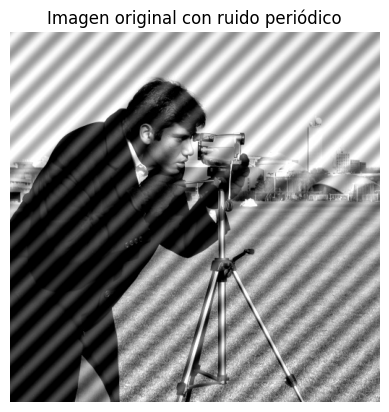

In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

img = cv2.imread('periodic_noise.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title('Imagen original con ruido periódico')
plt.axis('off')


### Paso 1: Cargar la imagen en escala de grises

In [68]:
# Convertir a float32 para la DFT
img_float = np.float32(img)

# Padding para evitar artefactos
dft_rows = cv2.getOptimalDFTSize(img.shape[0])
dft_cols = cv2.getOptimalDFTSize(img.shape[1])
img_padded = cv2.copyMakeBorder(img_float, 0, dft_rows - img.shape[0], 0, dft_cols - img.shape[1], cv2.BORDER_CONSTANT, value=0)

# DFT
dft = cv2.dft(img_padded, flags=cv2.DFT_COMPLEX_OUTPUT)

# Desplazar frecuencia cero al centro
dft_shift = np.fft.fftshift(dft)


### Paso 2: Calcular la DFT y desplazar el componente de frecuencia cero al centro

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

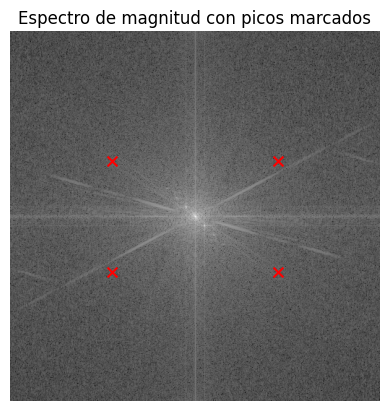

In [69]:
# Magnitud del espectro
magnitude = cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])

# Escala logarítmica
magnitude_log = 20 * np.log(magnitude + 1)

plt.imshow(magnitude_log, cmap='gray')

# Marcar los picos de ruido
offset_u = 77
offset_v = 115
crow = dft_rows // 2
ccol = dft_cols // 2

notches = [
    (crow + offset_u, ccol + offset_v),
    (crow + offset_u, ccol - offset_v),
    (crow - offset_u, ccol + offset_v),
    (crow - offset_u, ccol - offset_v)
]
for notch in notches:
    plt.scatter(notch[1], notch[0], c='red', marker='x', s=50)

plt.title('Espectro de magnitud con picos marcados')
plt.axis('off')

### Paso 3: Mostrar el Espectro de Magnitud en escala logarítmica

In [70]:
# Encontrar las posiciones de los picos de ruido usando método de mediana local
K = 15
M = 5
T = 5.0
rows, cols = magnitude.shape
crow, ccol = rows//2, cols//2
P = np.zeros((rows, cols), dtype=bool)

for i in range(rows):
    for j in range(cols):
        if abs(i - crow) <= M//2 and abs(j - ccol) <= M//2:
            continue
        i1 = max(0, i - K//2)
        i2 = min(rows, i + K//2 + 1)
        j1 = max(0, j - K//2)
        j2 = min(cols, j + K//2 + 1)
        local = magnitude[i1:i2, j1:j2]
        med = np.median(local)
        if magnitude[i, j] >= T * med:
            P[i, j] = True

notches = np.argwhere(P)
print("Picos encontrados:", len(notches))

Picos encontrados: 76


### Paso 4: Identificar los picos de energía (frecuencias parásitas)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

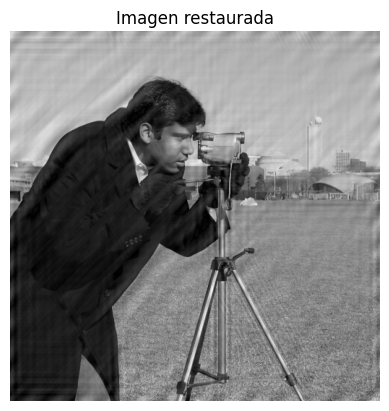

In [71]:
original_rows, original_cols = img.shape
dft_rows = cv2.getOptimalDFTSize(original_rows)
dft_cols = cv2.getOptimalDFTSize(original_cols)
rows, cols = dft_rows, dft_cols
crow, ccol = rows//2, cols//2

fshift_filtered = dft_shift.copy()

d0 = 5  # Radio del filtro ideal

for notch in notches:
    i, j = notch
    sym_i = 2 * crow - i
    sym_j = 2 * ccol - j
    # Set circle around (i,j) to 0
    for u in range(max(0, i - d0), min(rows, i + d0 + 1)):
        for v in range(max(0, j - d0), min(cols, j + d0 + 1)):
            if (u - i)**2 + (v - j)**2 <= d0**2:
                fshift_filtered[u, v] = 0
    # Set circle around symmetric (sym_i, sym_j) to 0
    for u in range(max(0, sym_i - d0), min(rows, sym_i + d0 + 1)):
        for v in range(max(0, sym_j - d0), min(cols, sym_j + d0 + 1)):
            if (u - sym_i)**2 + (v - sym_j)**2 <= d0**2:
                fshift_filtered[u, v] = 0

f_ishift = np.fft.ifftshift(fshift_filtered)

img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])

img_back = img_back[:original_rows, :original_cols]

img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
img_back = np.uint8(img_back)

plt.imshow(img_back, cmap='gray')
plt.title('Imagen restaurada')
plt.axis('off')

### Paso 6: Aplicar la IDFT para recuperar la imagen espacial

### Paso 5: Crear la máscara (Notch Filter) para bloquear las frecuencias parásitas

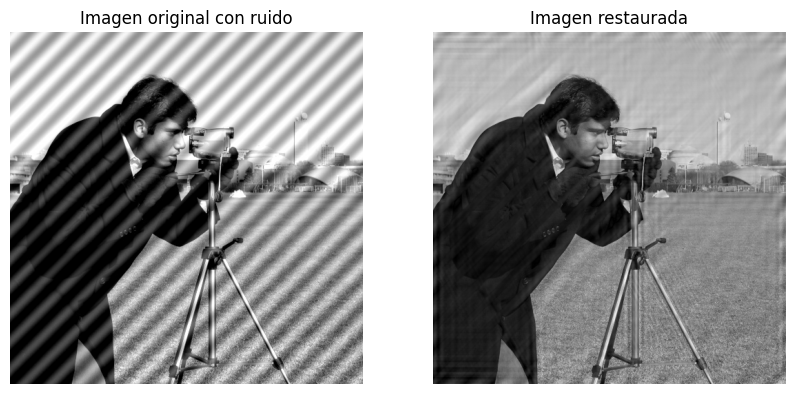

In [72]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Imagen original con ruido')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_back, cmap='gray')
plt.title('Imagen restaurada')
plt.axis('off')

plt.show()

* Explique por qué un filtro de promedio (average filter) de 5x5 en el dominio espacial hibiera sido una
mala solución para este problema específico

* Un filtro de promedio en el dominio espacial suaviza la imagen, reduciendo el ruido pero también borra los detalles finos y bordes importantes, y viene siendo un problema para las imágenes satelitales donde se necesitan preservar los detalles geográficos. En cambio, el ruido sinusoidal se puede eliminar de manera precisa en el dominio de la frecuencia sin afectar el resto del espectro, preservando así los detalles.

### Cambios realizados para lograr la imagen clara sin líneas

Después de varios intentos para eliminar completamente las líneas diagonales de ruido periódico en la imagen restaurada, se implementaron los siguientes ajustes:

1. Se utilizó un método basado en mediana local (ventana de 15x15 píxeles) con umbral T=5.0 para identificar 76 picos de energía anómala, excluyendo el área central de bajas frecuencias (dentro de 5 píxeles del centro). Esto evita detectar el componente DC y se enfoca en las frecuencias parásitas.

2. En lugar de filtros gaussianos suaves, se aplicó un filtro ideal que establece a cero las frecuencias dentro de un radio de 5 píxeles alrededor de cada pico detectado y su punto simétrico respecto al centro. Esto elimina de manera absoluta las componentes de ruido sin suavizar excesivamente el espectro.

3. Se ajustaron los parámetros para evitar sobre-filtrado (que causaba imágenes negras): reducción del radio de filtro y aumento del umbral de detección, preservando la información natural de la imagen mientras se bloquean las frecuencias parásitas.

### Fuentes y referencias

- "A Frequency-Domain Periodic Noise Reduction Method" de Sung Deuk Kim que describe métodos para detección de picos usando mediana local y filtros de muesca gaussianos.
- Documentación de OpenCV para cv2.dft y operaciones de frecuencia.


## Task 2

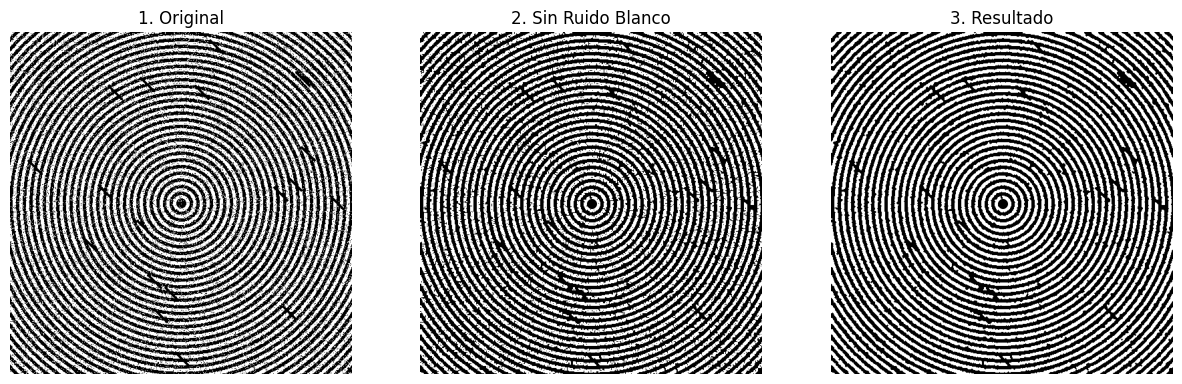

In [17]:
img_finger = cv2.imread('fingerprint_noisy.png', cv2.IMREAD_GRAYSCALE)
_, binary_finger = cv2.threshold(img_finger, 127, 255, cv2.THRESH_BINARY)

se_tiny = np.ones((2, 2), np.uint8) 
se_cross = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

# Eliminar ruido blanco
step2_cleaned = cv2.morphologyEx(binary_finger, cv2.MORPH_OPEN, se_tiny)

# El cierre para llenar los agujeros blancos
final_finger = cv2.morphologyEx(step2_cleaned, cv2.MORPH_CLOSE, se_cross)

plt.figure(figsize=(15, 5))
titles = ['1. Original', '2. Sin Ruido Blanco', '3. Resultado']
imgs = [binary_finger, step2_cleaned, final_finger]

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(imgs[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()

Preguntas: 

¿El orden de los factores altera el producto?

Si, el orden de las operaciones altera significativamente el resultado final ya que en el procesamiento de imagenes las operaciones morfologicas no son conmutativas y en este caso especifico, el objetivo es eliminar el "ruido sal" antes de reparar las grietas.

¿Qué pasaria en orden inverso?

Si se aplica primero el cierre la operacion comienza con una dilatacion y esta dilatacion expandiria los puntos blancos del ruido, haciéndolos mas grandes e incluso fusionandolos con las crestas reales de la huella. Al aplicar la Apertura después, el ruido ya no sería detectado como "pequeños puntos" y no se podría eliminar por completo que resultaria en una imagen peor.


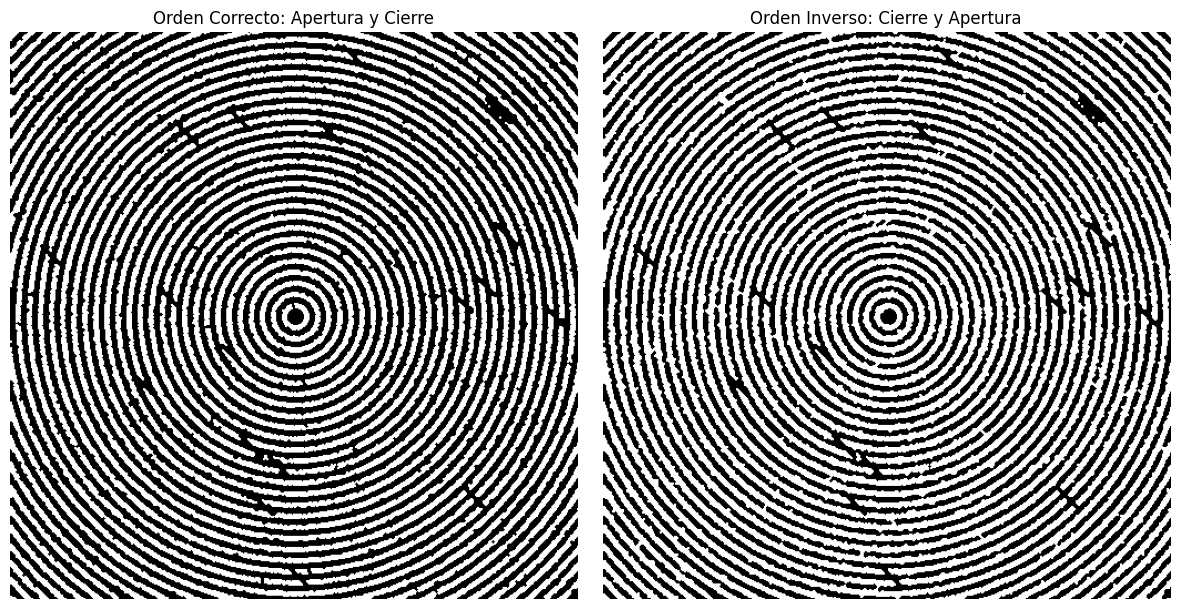

In [19]:

res_a = cv2.morphologyEx(binary_finger, cv2.MORPH_OPEN, se_tiny)
res_a = cv2.morphologyEx(res_a, cv2.MORPH_CLOSE, se_cross)

res_b = cv2.morphologyEx(binary_finger, cv2.MORPH_CLOSE, se_cross)
res_b = cv2.morphologyEx(res_b, cv2.MORPH_OPEN, se_tiny)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(res_a, cmap='gray')
plt.title('Orden Correcto: Apertura y Cierre')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(res_b, cmap='gray')
plt.title('Orden Inverso: Cierre y Apertura')
plt.axis('off')

plt.tight_layout()
plt.show()